In [ ]:
!pip install findiff
from NetClasses import *
from SobolevClasses import *
import pandas as pd

In [ ]:
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

Attempt to use neural networks to approximate functions in the Discrete Sobolev Space

## What we want to show

$$
\left\| f - \sum_{j=1}^{n} a_j(f) \varphi(A_j(\cdot) + b)  \right\|_p \leq c n^{-r/s} \left\| f \right\|_{W_{r,s}^{p}}
$$

i.e. the neural network can approximate the function in the Sobolev space with a rate of $n^{-r/s}$ w.r.t the Lp norm.

### Notation
- $r$ : smoothness of the function in the Sobolev space
- $p$ : $L^p$ norm to be used
- $s$ : dimension of the input space

In [ ]:
# gen_discrete_sin = FunctionSamples(lambda x: np.sin(x), n_samples=10000, n_inputs=1,n_outputs=1)
# ds = gen_discrete_sin.get_dataset()

In [ ]:
def RunSobolevTest(f,n_inputs=1,n_outputs=1,n_samples=200):
    """
    Input: f a function
    Output: Graph of final loss of varying width shallow networks
    """

    # Create Dataset Generator
    gen_func = FunctionSamples(f, n_samples=n_samples, n_inputs=n_inputs, n_outputs=n_outputs)
    ds = gen_func.get_dataset()

    def Lp_loss(y_true, y_pred, p=2):
        if p < 1:
            raise ValueError("p must be greater than or equal to 1")

        # Calculate the absolute difference raised to the power of p
        difference_power_p = abs(y_true - y_pred) ** p

        # Take the p-th root of the result
        return difference_power_p ** (1/p)

    # Take 20 Widths from 1->2500
    N = np.arange(1, 2500, 125)
    # Create empty dataframe to store results
    results = pd.DataFrame(columns=['N', 'Loss'])
    # Number of trials ran
    for i in range(20):
        # Create the network
        # Structure: number of neurons
        # Input Layer: n_inputs
        # Hidden layer: n
        # Output layer: n_outputs

        for n in tqdm(N, desc=f"Trial {i}"):
          with tf.device('/device:GPU:0'):
            net = ShallowNetwork(n_inputs,n,n_outputs).build_model()
            ds = gen_func.get_dataset()

            net.compile(optimizer='adam', loss=Lp_loss)
            net.fit(ds, epochs=50, verbose=0)
            loss = net.evaluate(ds, verbose=0)
            results = pd.concat([results, pd.DataFrame({'N': [n], 'Loss': [loss]})])
            # print(f"n: {n}, loss: {loss}")

    results.to_csv(f"Shallow{f.__name__}.csv")
    # Average the results
    results = results.groupby('N').mean()
    results.plot()
    plt.title(f"Sobolev Test for {f.__name__}")
    plt.xlabel("Width of Network")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.show()
    return results

Trial 19: 100%|██████████| 20/20 [02:55<00:00,  8.80s/it]


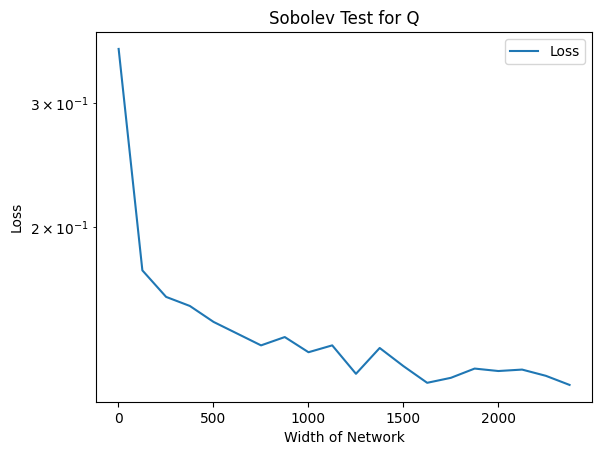

,Loss
N,
1,0.357443
126,0.173670
251,0.159287
376,0.154651
501,0.146813
626,0.141312
751,0.136007
876,0.139748
1001,0.133000


In [ ]:
def Q(x,y):
  return np.abs(x**2 - y**2)

RunSobolevTest(Q, n_inputs=2,n_outputs=1,n_samples=100)